# ResNet Notebook

This notebook is for reproducing the paper with ResNet.

## Dependencies

Let's setup and configure dependencies. Note that since torchviz is used, graphviz needs to be specially installed.

In [1]:
%load_ext tensorboard
%matplotlib widget

import contextlib
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
import time
import timm
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.datasets as datasets
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torchvision import transforms as T
from torchviz import make_dot # This requires external downloads as well
import tqdm

In [ ]:
# Reproducibility
def seed_worker(worker_id):
    """
    Sets the seed of the worker to depend on the initial seed. Credit to
    https://pytorch.org/docs/stable/notes/randomness.html
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
torch.manual_seed(0)
# For DataLoaders
g = torch.Generator().manual_seed(0)

In [ ]:
# Prepare progress bar
tqdm_variant = tqdm.tqdm # Assume not in Jupyter
try:
    # Credit https://stackoverflow.com/a/39662359
    shell_name = get_ipython().__class__.__name__
    if shell_name == "ZMQInteractiveShell":
        # Case in Jupyter
        tqdm_variant = tqdm.notebook.tqdm
except NameError:
    # Probably no iPhython instance, just use standard
    pass

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Plotting and Debugging Tools

Let's create some helpful functions for plotting.

In [3]:
# Adapted from Steven's ModelExamples
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
def display_batch_sample(loader):
    dataiter = iter(loader)
    imgs, labels = next(dataiter)
    img_grid = torchvision.utils.make_grid(imgs)
    imgs, labels = imgs.to(device), labels.to(device)
    matplotlib_imshow(img_grid)

In [ ]:
def plot_cumulative_dist(
    baseline_observations,
    stabilized_observations
):
    """Plot our reproduction of Figure 7."""
    fig, ax = plt.subplots()
    ax.set_title("Cumulative Distributions")
    ax.set_xlabel("Feature Distance")
    ax.set_ylabel("Cumulative Fraction")
    ax.hist(
        baseline_observations,
        round(np.sqrt(len(baseline_observations))),
        density=True,
        histtype="step",
        cumulative=True,
        label="Baseline"
    )
    ax.hist(
        stabilized_observations,
        round(np.sqrt(len(stabilized_observations))),
        density=True,
        histtype="step",
        cumulative=True,
        label="Stabilized"
    )
    ax.legend()
    fig.show()

In [8]:
def show_first_triplet(queries, positives, negatives):
    a, b, c = queries[0], positives[0], negatives[0]
    ToPIL = T.ToPILImage() # Converting function
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(ToPIL(a))
    ax[1].imshow(ToPIL(b))
    ax[2].imshow(ToPIL(c))
    fig.show()

In [8]:
def plot_precision_vs_quality(
    qualities,
    baseline_precision,
    stabilized_precision
):
    """Plots precision vs quality as in Figure 9."""
    fig, ax = plt.subplots()
    ax.set_title("Precision vs Quality")
    ax.set_xlabel("JPEG Quality")
    ax.set_ylabel("Precision@top-1")
    plt.plot(qualities, baseline_precision, label="Baseline")
    plt.plot(qualities, stabilized_precision, label="Stabilized")
    ax.legend()
    fig.show()

In [38]:
def debug_distances(triplet_ranking_model, batch, item_idx=0):
    with torch.no_grad():
        output = triplet_ranking_model(*map(lambda x : x.to(device), batch))
        qfeat = output[item_idx][0]
        pfeat = output[item_idx][1]
        nfeat = output[item_idx][2]
        pos_dist = torch.sqrt(((qfeat - pfeat)**2).sum()).item()
        neg_dist = torch.sqrt(((qfeat - nfeat)**2).sum()).item()
        print(f"Distance to positive: {pos_dist}, to negative: {neg_dist}")

This part is also helpful for storing results of training:

In [ ]:
def _def_save_filename(iteration_number : int, is_model : bool):
    """
    Returns a save filename from an iteration number, and whether the
    thing being saved is the model or the loss progress.
    """
    # Make sure inputs are okay (no directory traversal attacks!)
    if not isinstance(iteration_number, int):
        raise TypeError("Iteration number should be an integer.")

    # Retrieve proper name
    if is_model:
        return os.path.join(
            os.path.dirname(os.path.abspath("")),
            f"model_save_{iteration_number}_{int(time.time())%1000000:06}.pt"
        )
    return os.path.join(
        os.path.dirname(os.path.abspath("")),
        f"progress_save_{iteration_number}_{int(time.time())%1000000:06}.pt"
    )

#
# This class will make recording information easier
#
class TrainResult:
    """
    Hold the results of a training round. Basically a nice wrapper.

    Losses and accuracies should be averages over a batch for plot
    labels to make sense.

    Use whichever storage makes sense, but if one doesn't use the
    storage then don't expect the corresponding plots to do anything.
    """

    def __init__(self, model):
        """
        Constructor - prepare local variables. Include model since the
        one provided to trainer will likely be moved to a different
        device. Provide the one that is actually trained here, and then
        it can be used.
        """
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_accuracy_history = []
        self.val_accuracy_history = []
        self.time_training = 0.0
        self.time_validating = 0.0
        self.model = model

    def plot_loss_train_valid_curves(self, ax, show_legend : bool=True):
        """Use matplotlib to show training curves. Supply axis in ax."""
        ax.plot(self.train_loss_history, label="Train")
        ax.plot(self.val_loss_history, label="Test")
        ax.title(f"Model Loss")
        ax.xlabel("Iteration")
        ax.ylabel("Loss")
        if show_legend:
            ax.legend()

    def plot_accuracy_train_valid_curves(self, ax, show_legend=True):
        """Use matplotlib to show training curves. Supply axis in ax."""
        ax.plot(self.train_accuracy_history, label="Train")
        ax.plot(self.val_accuracy_history, label="Test")
        ax.title(f"Model Accuracy")
        ax.xlabel("Iteration")
        ax.ylabel("Accuracy")
        if show_legend:
            ax.legend()

    def print_time_info(self):
        """Prints some lines with information about timing."""
        print(f"Spent {round(self.time_training)} seconds training.")
        print(f"Spent {round(self.time_validating)} seconds evaluating.")

    def full_analysis(self, axs):
        """Display all analysis plots and print time information."""
        if len(self.train_loss_history) > 0:
            self.plot_loss_train_valid_curves(axs[0])
        if len(self.train_accuracy_history) > 0:
            self.plot_accuracy_train_valid_curves(ax[1])
        if self.time_training > 0.0:
            self.print_time_info()

    def save(self, save_filename_func, count : int=0):
        """
        Uses the save_filename_func provided with the count to create
        files that save the models current weights and the training
        progress so far.

        For count, 0 is by convention the final version.
        """
        # Save model
        torch.save(self.model.state_dict(), save_filename_func(count, True))
        # Save progress
        with open(save_filename_func(count, False), "wb") as file_obj:
            pickle.dump(
                {
                    "train_loss_history" : self.train_loss_history,
                    "val_loss_history" : self.val_loss_history,
                    "train_accuracy_history" : self.train_accuracy_history,
                    "val_accuracy_history" : self.val_accuracy_history,
                    "time_training" : self.time_training,
                    "time_validating" : self.time_validating
                }, file_obj
            )

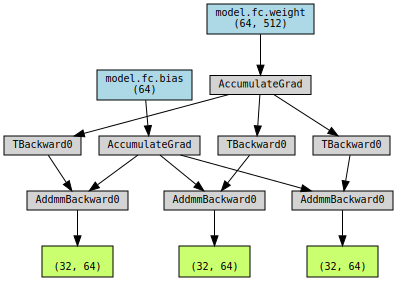

In [90]:
def gradient_sanity_display(model, input_iter):
    """
    Show a computational graph for a model on device given an iterable
    of inputs to provide to the model.
    """
    res = model(*[item.to(device) for item in input_iter])
    make_dot(res, params=dict(model.named_parameters()))

## Metrics

Let's prepare some evaluation functions.

In [7]:
def classifier_get_accuracy(model_output, labels):
    """
    Given model output and labels, finds the average accuracy over the 
    batch.
    """
    preds = model_output.topk(1, dim=1)[1].t().flatten()
    return (preds == labels).sum() / len(preds)

In [9]:
def stable_classifier_get_accuracy(model_output, labels):
    """For stability trained classifier, finds the accuracy"""
    return (
        torch.sum(
            torch.split(
                model_output, CLASS_NUMBER, 1
            )[0].topk(1, dim=1)[1].t().flatten()
            == labels
        )
        / len(model_output)
   )

## Experiments

Let's make some functions to run experiments on models.

For the following, see how closely the triplet ranking models think compressed versions of the same images are.

In [ ]:
def make_observations(baseline_model, stabilized_model, imagefolder):
    """
    Given a model trained for triplet ranking, make duplicate detection
    observations.
    """
    baseline_observations = []
    stabilized_observations = []
    
    for img_name in os.listdir(imagefolder):
        #
        # Deal with images
        #
        original_img = Image.open(image_fpath)
        # Thanks https://stackoverflow.com/a/30771751
        buffer = StringIO.StringIO()
        original_img.save(buffer, "JPEG", optimize=True, quality=50)
        compressed_img = Image.open(buffer)
        
        orig_tensor = T.ToTensor(original_img)
        comp_tensor = T.ToTensor(compressed_img)
        #
        # Make observations
        #
        baseline_model.eval()
        stabilized_model.eval()
        with torch.no_grad():
            # Baseline
            original_rep = baseline_model(orig_tensor)
            compressed_rep = baseline_model(comp_tensor)
            dist = torch.sqrt(((original_rep - compressed_rep)**2).sum())
            baseline_observations.append(dist)
            # Stabilized
            original_rep = stabilized_model(orig_tensor)
            compressed_rep = stabilized_model(comp_tensor)
            dist = torch.sqrt(((original_rep - compressed_rep)**2).sum())
            stabilized_observations.append(dist)
            
    return baseline_observations, stabilized_observations

## Datasets

Let's prepare some datasets. First, we'll make a custom dataset.

In [61]:
# NOTE: an alternative to this paradigm is loading all the images using
# the transform as a catalogue onto main memory, then detach on access
# TODO - refactor
class TripletRankingDataset(torch.utils.data.Dataset):
    def __init__(self,
                 img_dir : str,
                 pos_per_img : int,
                 neg_per_pos : int,
                 transform=None,
                 training=True
                ):
        """
        Point at directory which has subdirectories corresponding to
        each class. Supply the number of positive images per image in
        the subdirectories and the number of negative images to combine
        with.
        """
        if transform is None:
            transform = nn.Identity()
        self.transform = transform
        self.mode = "RGB"#ImageReadMode.RGB
        
        #
        # Initialize triplets
        #
        self.triplets = [ ]
        
        if training:
            self._train_init(img_dir, pos_per_img, neg_per_pos)
        else:
            self._val_init(img_dir, pos_per_img, neg_per_pos)
        
    def _train_init(self, img_dir, pos_per_img, neg_per_pos):
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
        for subdir_path in subdirectories_paths:
            img_per_class = len(os.listdir(subdir_path))
            break
        randoms = np.random.randint(
            0,
            img_per_class,
            (
                len(subdirectories_paths),
                img_per_class,
                pos_per_img,
                neg_per_pos + 1 # Last for positive selection
            ),
            dtype="int16"
        )
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            # Iterate over images
            for img_idx, img in enumerate(os.listdir(subdir_path)):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    pos_rand = randoms[subdir_idx][img_idx][pos_it][-1]
                    # Adjust on equal
                    if pos_rand == pos_it:
                        if pos_rand == 0:
                            pos_rand += 1
                        else:
                            pos_rand -= 1
                    # Form name
                    pos_path = os.path.join(
                        subdir_path,
                        f"{class_names[subdir_idx]}_{pos_rand}.JPEG"
                    )
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        neg_rand = randoms[subdir_idx][img_idx][pos_it][neg_it]
                        # Form name
                        neg_path = os.path.join(
                            neg_class_path,
                            f"{neg_class}_{neg_rand}.JPEG"
                        )
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
                        
    def _val_init(self, img_dir, pos_per_img, neg_per_pos):
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
            
        img_per_class = dict()
        img_names = []
        for idx in range(len(class_names)):
            subdir_path = subdirectories_paths[idx]
            class_name = class_names[idx]
            img_names.append(list(os.listdir(subdir_path)))
            img_per_class[class_name] = len(img_names[-1])
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            this_dir = img_names[subdir_idx]
            # Iterate over images
            for img_idx, img in enumerate(this_dir):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    # Form name
                    rand_idx = np.random.choice([
                        *range(pos_it),
                        *range(pos_it + 1, img_per_class[class_names[pos_it]])
                    ])
                    pos_name = this_dir[rand_idx]
                    # Form path
                    pos_path = os.path.join(subdir_path, pos_name)
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        # Select from the directory
                        neg_name = np.random.choice(img_names[class_rand])
                        # Form name
                        neg_path = os.path.join(neg_class_path, neg_name)
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
        
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        this_triplet = self.triplets[idx]
        #query = self.transform(read_image(this_triplet[0], self.mode))
        #positive = self.transform(read_image(this_triplet[1], self.mode))
        #negative = self.transform(read_image(this_triplet[2], self.mode))
        query = self.transform(Image.open(this_triplet[0]).convert(self.mode))
        positive = self.transform(Image.open(this_triplet[1]).convert(self.mode))
        negative = self.transform(Image.open(this_triplet[2]).convert(self.mode))
        return query, positive, negative

The following is helpful to keep around:

In [ ]:
data_dir = os.path.join(os.path.abspath(""), "tiny-imagenet-200")

We'll create dataset objects as we go since they take up memory.

## Models

We'll similarly create model objects as we go along, but this section contains things that simplify making them.

### Helper Transformations

In [ ]:
# Credit https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return (
            tensor
            + torch.empty(tensor.size(), device=device).normal_() * self.std
            + self.mean
        )
    
    def __repr__(self):
        return (
            self.__class__.__name__
            + '(mean={0}, std={1})'.format(self.mean, self.std)
        )

### Wrappers

In [78]:
class TripletRanker(nn.Module):
    """Triplet ranking model."""
    
    def __init__(self, model):
        """Creates a triplet ranker out of the model."""
        super().__init__()
        self.model = model
        
    def forward(self, queries, positives, negatives):
        """Send batch of triplets through."""
        queries_encode = self.model(queries)
        positives_encode = self.model(positives)
        negatives_encode = self.model(negatives)
        return queries_encode, positives_encode, negatives_encode

In [ ]:
class StabilityTrainingModel(torch.nn.Module):
    def __init__(self, other_model, perturbation=None):
        """
        Wraps another model to allow for stability training. May specify
        custom perturbation transformation.
        """
        super().__init__()
        self.model = other_model
        
        if perturbation is None:
            self.perturb = AddGaussianNoise(0, 0.04)
        else:
            self.perturb = perturbation
    
    def forward(self, x):
        """Apply the model to some input."""
        return self.model(x), self.model(self.perturb(x))

### Model Classes

In [ ]:
# This will act like a class
def RobustResnet():
    """
    Retrieve a fresh ResNet ready for stability training and fine
    tuning.
    """
    bare_resnet = torchvision.models.resnet18(pretrained=True)
    for param in bare_resnet.parameters():
        param.requires_grad = False
    bare_resnet.fc = nn.Linear(512, CLASS_NUMBER, bias=True)
    
    return StabilityTrainingModel(bare_resnet)

## Training Functions

Factoring some common patterns:

In [83]:
def classifier_epoch(
    model,
    loader,
    optimizer,
    device,
    loss_func,
    result,
    training=True
):
    loss = torch.Tensor([0])
    avg_loss = 0
    
    if training:
        model.train()
    else:
        model.eval()
    start = time.perf_counter()
    with contextlib.ExitStack() as stack: # For validation/training
        if not training:
            stack.enter_context(torch.no_grad()) # No gradients
        for imgs, labels in tqdm_variant(
            loader,
            desc=f"{'Training' if training else 'Validation'} Iteration",
            disable=False
        ):
            if training:
                # Prepare optimizer
                optimizer.zero_grad(set_to_none=True)

            # Prepare relevant variables
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)

            # Determine loss
            loss = loss_func(out, labels)

            # Store intermediate results - note average over batch
            item = loss.item()
            avg_loss += item
            if training:
                result.train_loss_history.append(item)
            else:
                result.val_loss_history.append(item)

            # Calculate accuracy
            acc = (
                torch.sum(
                    out.topk(1, dim=1)[1].t().flatten() == labels
                ) / len(out)
            ).item()
            if training:
                result.train_accuracy_history.append(acc)
            else:
                result.val_accuracy_history.append(acc)

            if training:
                loss.backward() # Get gradients
                optimizer.step() # Descend gradients
    end = time.perf_counter()
    if training:
        result.time_training += end - start
    else:
        result.time_validating += end - start
    
    return avg_loss / len(loader)

In [ ]:
def triplet_epoch(
    model,
    loader,
    optimizer,
    device,
    loss_func,
    result,
    training=True
):
    loss = torch.Tensor([0])
    avg_loss = 0
    
    if training:
        model.train()
    else:
        model.eval()
    start = time.perf_counter()
    with contextlib.ExitStack() as stack: # For validation/training
        if not training:
            stack.enter_context(torch.no_grad()) # No gradients
        for queries, positives, negatives in tqdm_variant(
            loader,
            desc=f"{'Training' if training else 'Validation'} Iteration",
            disable=False
        ):
            if training:
                # Prepare optimizer
                optimizer.zero_grad(set_to_none=True)

            # Prepare relevant variables
            queries = queries.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)
            out = model(queries, positives, negatives)

            # Determine loss
            loss = loss_func(*out)

            # Store intermediate results - note average over batch
            item = loss.item()
            avg_loss += item
            if training:
                result.train_loss_history.append(item)
            else:
                result.val_loss_history.append(item)

            if training:
                loss.backward() # Get gradients
                optimizer.step() # Descend gradients
    end = time.perf_counter()
    if training:
        result.time_training += end - start
    else:
        result.time_validating += end - start
    
    return avg_loss / len(loader)

## Miscellaneous Helpers


Some constants:

In [4]:
# Weight of the stability objective
ALPHA = 0.01

CLASS_NUMBER = 200

Loss function things for stability trained classifiers:

In [6]:
classifier_objective = nn.CrossEntropyLoss()
classifier_stability_loss = nn.CrossEntropyLoss()

def full_loss(clean_output, distort_output, label):
    return (
        training_objective(clean_output, label)
        + ALPHA * classifier_stability_loss(distort_output, clean_output)
    )

ResNet is made to be used with data transformed as so:

In [ ]:
resnet_transform = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Training

Now, let's do some training!

### Classifiers

#### Baseline

Let's train a baseline ResNet. First, prepare the data.

In [9]:
class_dataset_train = datasets.ImageFolder(
    os.path.join(data_dir, "train"),
    transform=resnet_transform
)
class_dataset_val = datasets.ImageFolder(
    os.path.join(data_dir, "val"),
    transform=resnet_transform
)

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    class_dataset_train,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    class_dataset_val,
    batch_size=batch_size,
    num_workers=0
)

Next, prepare the model object.

In [34]:
# Default variation. Note pretrained
resnet = torchvision.models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False
    
# Replace last, note now unfrozen and we'll fine tune
resnet.fc = nn.Linear(512, 200, bias=True)

# Send to GPU, if possible
resnet = resnet.to(device)

Learning controllers:

In [35]:
optimizer = optim.SGD(resnet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=2,
    threshold=0.1
)
# May try OneCycleLR, annealers

The loss function:

In [36]:
resnet_loss = classifier_objective

Keep the result in here:

In [37]:
resnet_result = TrainResult(optimizer)

The actual training loop:

In [ ]:
# Train for some number of epochs
EPOCH_COUNT = 1#20
SAVE_PERIOD = 3

best_loss = float("inf")
best_count = 0
for epoch in tqdm_variant(
    range(EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")
    
    # Train
    train_loss = classifier_epoch(
        resnet,
        train_loader,
        optimizer,
        device,
        resnet_loss,
        resnet_result
    )

    # Validation
    val_loss = classifier_epoch(
        resnet,
        val_loader,
        device,
        resnet_loss,
        resnet_result,
        training=False
    )
    
    # Update scheduling
    scheduler.step(val_loss)
    
    # Save a copy just in case
    if val_loss < best_loss:
        torch.save(
            resnet, 
            os.path.join(
                os.path.abspath(""),
                f"best_resnet_classifier_{best_count}_{int(time.time())}.pt"
            )
        )
        best_count += 1
        best_loss = val_loss
        
    if epoch % SAVE_PERIOD == SAVE_PERIOD - 1:
        torch.save(
            resnet,
            os.path.join(
                os.path.abspath(""),
                f"resnet_classifier_{epoch}_{int(time.time())}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Let's view the results:

In [ ]:
fig, axs = plt.subplots(1, 2)
resnet_result.full_analysis(axs)

#### Stability Trained

TODO

In [3]:
# TODO

### Triplet Ranking

Next, let's train some triplet ranking models.



#### Baseline

Prepare data:

In [62]:
train_path = os.path.join(data_dir, "train")
val_path = os.path.join(data_dir, "val")
trd = TripletRankingDataset(train_path, 2, 2, transform=resnet_transform)
trd_val = TripletRankingDataset(
    val_path,
    1,
    1,
    transform=resnet_transform,
    training=False
)

batch_size = 32
tr_train_loader = torch.utils.data.DataLoader(trd, batch_size=batch_size,
                                     num_workers=0, shuffle=True)
tr_val_loader = torch.utils.data.DataLoader(trd_val, batch_size=batch_size,
                                     num_workers=0)

Prepare new model that maps into a 64 dimensional encoding space. Note that this is less than the 200 classes.

In [79]:
resnet_encoder = torchvision.models.resnet18(pretrained=True)

for param in resnet_encoder.parameters():
    param.requires_grad = False
    
resnet_encoder.fc = nn.Linear(512, 64, bias=True) # 64-Dimensional Encoding

resnet_triplet_ranking = TripletRanker(resnet_encoder).to(device)

Training controllers:

In [80]:
rtr_optimizer = optim.SGD(resnet_triplet_ranking.parameters(), lr=0.01)
rtr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    rtr_optimizer,
    factor=0.5,
    patience=2,
    threshold=0.1
)
# May try OneCycleLR, annealers

Result:

In [81]:
rtr_result = TrainResult(resnet_triplet_ranking)

Triplet loss:

In [82]:
rtr_loss = nn.TripletMarginLoss(1.0, 2)

Training loop:

In [ ]:
# Train for some number of epochs
RTR_EPOCH_COUNT = 20
RTR_SAVE_PERIOD = 3

loss = torch.Tensor([0])
rtr_best_loss = float("inf")
rtr_best_count = 0
for epoch in tqdm_variant(
    range(RTR_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # Debug learning rate
    print(f"Current Learning Rate: {rtr_optimizer.param_groups[0]['lr']}")
    
    train_loss = triplet_epoch(
        resnet_triplet_ranking,
        tr_train_loader,
        rtr_optimizer,
        device,
        rtr_loss,
        rtr_result
    )

    val_loss = triplet_epoch(
        resnet_triplet_ranking,
        tr_val_loader,
        rtr_optimizer,
        device,
        rtr_loss,
        rtr_result,
        training=False
    )
    
    # Save a copy for safety
    if val_loss < rtr_best_loss:
        torch.save(
            resnet_triplet_ranking, 
            os.path.join(
                os.path.abspath(""),
                f"best_rtr_{best_count}_{int(time.time()) % 1000000:06}.pt"
            )
        )
        rtr_best_count += 1
        rtr_best_loss = val_loss
        
    if epoch % RTR_SAVE_PERIOD == RTR_SAVE_PERIOD - 1:
        torch.save(
            resnet_triplet_ranking,
            os.path.join(
                os.path.abspath(""),
                f"rtr_{epoch}_{int(time.time()) % 1000000:06}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Let's double check gradient calculations went well:

In [ ]:
gradient_sanity_display(resnet_triplet_ranking, next(iter(tr_train_loader))[0])

#### Stability Trained

In [ ]:
# TODO

## Experiments and Plot Generation

In [6]:
# TODO